# Processing GEM2 and magnaprobe data

**Adam Steer**

**May 2022**

From Magnaprobe and GEM2 measurements we get snow depth at about 1-2m along track resolotion, and combined snow + ice depth at some unknown resolution.

From these datasets, we need to generate snow depth (done!), ice thickness, draft and freeboard.

For ice thickness, draft and freeboard we rely on some assumptions about hydrostatic equilibrium and density of snow and ice. Using those, we model freeboard and draft using snow depths from the magnaprobe and combined snow and ice thickness from the GEM2 as constraints.

This notebook uses the approach:

- collect drift-corrected magnaprobe data into a set of point geometries
- collect drift-corrected GEM2 data into a set of point geometries
- test each magnaprobe point and find GEM2 data within 2.5 m radius (5m diameter)
- collect the median of GEM2 points found in that radius
- subtract magnaprobe snowdepth from median of GEM2 points
- use median GEM2 data, magnaprobe snow depth, and snow/ice density observations to compute ice thickness, draft and freeboard

This will result in a lot of overlapping data - for example two consecutive magnaprobe points are very likely to have overlap in their region where GEM2 data are collected. Given that GEM2 has a footprint of approximately 4 m diamter, this simple relfects the reality of how the measurements are collected. If needed, spatial filtering can be done later.


In [1]:
## import all the things we need

import os

import numpy as np

from scipy import stats

import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
plt.rcParams['font.size'] =18
inches = 2.51

from shapely import geometry

import pyproj

# array functions, used to generate moving standard deviations
import bottleneck as bn


In [2]:
# declare a function to compute freeboard
def find_fi(zi, zs, dwater, dice, dsnow):
    
    #derived by Claire Trenham, CSIRO, and Adam Steer.
    fi = (((dwater - dice) * zi) - dsnow * zs) / dwater
    
    return fi

# A stats printing function
def printstats(inputdata):
    print("number of observations: {}".format(len(inputdata)))
    print("min: {}".format(np.nanmin(inputdata)))
    print("max: {}".format(np.nanmax(inputdata)))
    print("mean: {}".format(np.nanmean(inputdata)))
    print("median: {}".format(np.nanmedian(inputdata)))
    print("standard deviation: {}".format(np.nanstd(inputdata)))
    print("skewness: {}".format(stats.skew(inputdata)))
    

In [3]:
## set some phsyical properties, these are used to compute sea ice freeboard

# density of seawater
d_water = 1027

# density of sea ice
d_ice = 915

# density of snow
d_snow = 350

### Start loading MP data

In [4]:
mp_rawdata = pd.read_csv("/mnt/documents/JC2-2/P10-11092021/magnaprobe/MPdata-driftcorrected-datefixed-12092021.csv",
                      skiprows = 10)

In [5]:
mp_rawdata

timestamp        easting       northing  snowdepth
0     12-09-2021T07:37:17.66  185395.228388 -344100.442717    0.00380
1     12-09-2021T07:37:22.04  185394.291896 -344100.991911    1.02300
2     12-09-2021T07:37:23.64  185394.416966 -344101.080329    0.05043
3     12-09-2021T07:37:27.54  185394.033588 -344100.732756    1.20800
4     12-09-2021T07:37:28.82  185394.222835 -344100.793055    1.20800
...                      ...            ...            ...        ...
5605  12-09-2021T14:34:43.53  185390.551396 -344107.387526    0.00100
5606  12-09-2021T14:34:49.24  185393.366131 -344107.704893    1.20300
5607  12-09-2021T14:34:50.25  185394.264226 -344108.129682    1.18000
5608  12-09-2021T14:34:52.27  185395.704335 -344108.366242    0.00100
5609  12-09-2021T14:34:53.92  185396.061061 -344108.396030    1.18900

[5610 rows x 4 columns]

In [6]:
mp_data = mp_rawdata.loc[(mp_rawdata["snowdepth"] > 0) & (mp_rawdata["snowdepth"] < 1.2)]

In [7]:
# generate a list of tuple coordinate pairs
xypairs = list(zip(mp_data["easting"].values, mp_data["northing"].values))

In [8]:
xypairs[0]

(185395.22838831175, -344100.4427168474)

In [9]:
# make geometries from each point
mp_points = []

for pair in xypairs:
    mp_points.append(geometry.Point(pair[0], pair[1]))

In [10]:
# make buffered points, with 24 sided 'circles'

mp_buffers = []
for point in mp_points:
    mp_buffers.append(point.buffer(5, resolution=36))

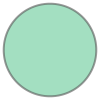

In [11]:
mp_buffers[0]

### Check distance between magnaprobe samples

get difference between array elements in X and Y coordinates, do some Pythagoras to get an idea of the magnaprobe observation step size.

This gives an approximate along-track ground sampling distance, useful for setting filtering windows later

In [12]:
stepX = np.diff(mp_data["easting"].values-5)
stepY = np.diff(mp_data["northing"].values)
mp_point2point = np.sqrt(stepX**2 + stepY**2)

In [13]:
printstats(mp_point2point)

number of observations: 5527
min: 0.026104783257137866
max: 56.625836311218364
mean: 1.0893690862093133
median: 0.9726637724731696
standard deviation: 0.9327384916502353
skewness: 38.98156411048066


## Read and geometry-ify GEM2 data

In [14]:
gem2_data = pd.read_csv("/mnt/documents/JC2-2/P10-11092021/gem2/GEM2data-12092021-driftcorrected.csv",
                      skiprows = 10, low_memory = False)

In [15]:
gem2_data[0:5]

time   record_id        easting       northing   xc  \
0  2021-09-12T07:38:54.375000           2  185385.500320 -344111.174027  0.0   
1  2021-09-12T07:38:54.476562           3  185385.499935 -344111.170755  0.0   
2  2021-09-12T07:38:54.578125           4  185385.499616 -344111.167605  0.0   
3  2021-09-12T07:38:54.671875           5  185385.499114 -344111.164849  0.0   
4  2021-09-12T07:38:54.773437           6  185385.498816 -344111.161734  0.0   

    yc  f450Hz_hcp_i  f450Hz_hcp_q  f1530Hz_hcp_i  f1530Hz_hcp_q  \
0  0.0         1.467         0.860          0.873          0.853   
1  0.0         1.054         0.879          0.889          0.853   
2  0.0         0.856         0.859          0.945          0.844   
3  0.0         1.441         0.847          0.817          0.845   
4  0.0         1.457         0.820          0.796          0.855   

   f5310Hz_hcp_i   f5310Hz_hcp_q  f18330Hz_hcp_i   f18330Hz_hcp_q  \
0          0.858           0.851           0.860            0.842   
1          0.862           0.852           0.860            0.841   
2          0.861           0.851           0.863            0.842   
3          0.861           0.852           0.865            0.843   
4          0.869           0.852           0.861            0.842   

   f63030Hz_hcp_i   f63030Hz_hcp_q  
0           0.856            0.777  
1           0.854            0.778  
2           0.854            0.776  
3           0.854            0.775  
4           0.855            0.780

In [16]:
gem2_data.keys()

Index(['time', ' record_id', 'easting', 'northing', ' xc', ' yc',
       ' f450Hz_hcp_i', ' f450Hz_hcp_q', ' f1530Hz_hcp_i', ' f1530Hz_hcp_q',
       ' f5310Hz_hcp_i', ' f5310Hz_hcp_q', ' f18330Hz_hcp_i',
       ' f18330Hz_hcp_q', ' f63030Hz_hcp_i', ' f63030Hz_hcp_q'],
      dtype='object')

### check distance between GEM2 samples

This gives an approximate along-track ground sampling distance, useful for setting filtering windows later

In [17]:
stepX = np.diff(gem2_data["easting"].values)
stepY = np.diff(gem2_data["northing"].values)

gem2_point2point = np.sqrt(stepX**2 + stepY**2)

In [18]:
printstats(gem2_point2point)

number of observations: 66006
min: 5.1358344635637294e-05
max: 8.746041272065263
mean: 0.06375959988864802
median: 0.06542667927738909
standard deviation: 0.08212549297853212
skewness: 68.61426375405458


## Check that GEM2 and Magnaprobe coordinates line up!

Here, we can add a manual XY offset (translation) to line GEM2 and magnaprobe coordinates up as closely as possible. 

Circular windows around each Magnaprobe point are also shown, to get an idea of where we will find spatially-matched data.

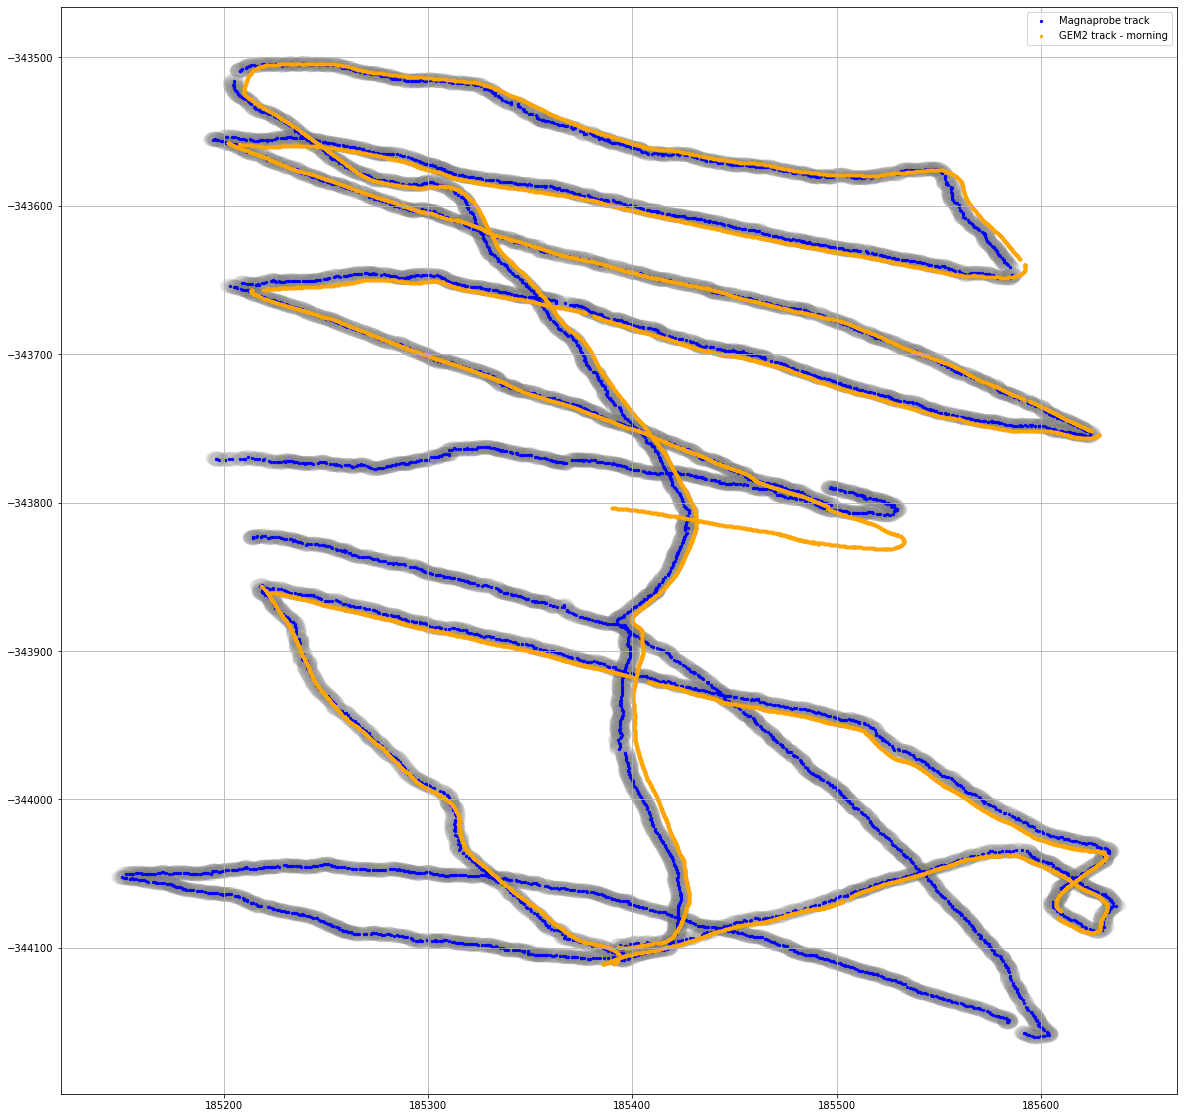

In [19]:
fig = plt.figure(figsize=(20,20))

for dot in mp_buffers:    
    xs, ys = dot.boundary.xy    
    plt.fill(xs, ys, alpha=0.2, fc='grey', ec='none')

plt.scatter(mp_data["easting"].values, mp_data["northing"].values, s=5,
            c='Blue', label = "Magnaprobe track")
plt.scatter(gem2_data["easting"].values, gem2_data["northing"].values,
            c = 'Orange', label = "GEM2 track - morning", s=5)


plt.legend()
plt.grid()

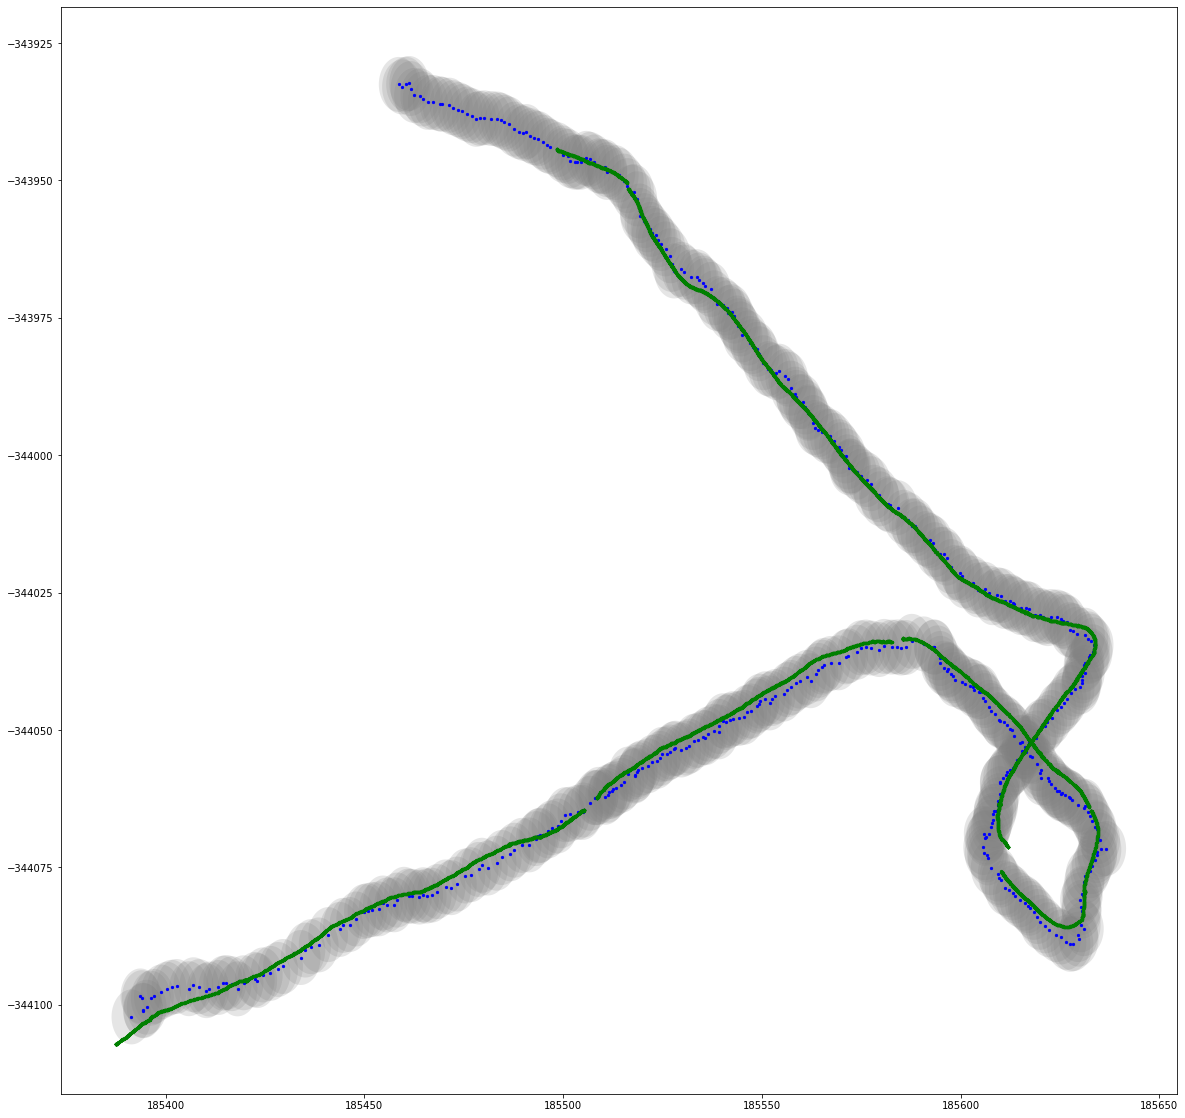

In [20]:
fig = plt.figure(figsize=(20,20))

for dot in mp_buffers[0:500]:    
    xs, ys = dot.boundary.xy    
    plt.fill(xs, ys, alpha=0.2, fc='grey', ec='none')

plt.scatter(mp_data["easting"].values[0:500], mp_data["northing"].values[0:500], s=5,
            c='Blue', label = "Magnaprobe track")

plt.scatter(gem2_data["easting"].values[0:12000]+2,
            gem2_data["northing"].values[0:12000]+4,
            c = 'Green', label = "GEM2 track - afternoon", s=5)



Next, add the offsets we needed to align data to the data themselves...

In [21]:
# Add offsets we derived in the plot above

gem2_xypairs = list(zip(gem2_data_morning["easting"].values+2,
                                gem2_data_morning["northing"].values+4))


NameError: name 'gem2_data_morning' is not defined

In [ ]:
# make geometries from each point
gem2_points = []

for pair in gem2_xypairs:
    gem2_points.append(geometry.Point(pair[0], pair[1]))

In [ ]:
# hmm. we have to append a lot of datasets also...

#gem2data = gem2_data_morning.copy()

In [ ]:
#gem2_data = pd.concat([gem2_data_morning,gem2_data_afternoon])

## Select GEM2 data points to use

- find GEM2 points within the buffer from MP points
- collect GEM2 observations matching those points
- compute the median of GEM2 observations
- assemble an array of MP and matching median GEM2 observations

In [ ]:
%%time 

mp_ind = 0
gem2_ind = 0
bufferpoints = []
collected_points = []

# iterate over MP buffers
for buffer in mp_buffers:
    #print("buffer {}".format(mp_ind))
    #then over gem2 points - the whole array
    for thispoint in gem2_points:
        
        #if the buffer contains the point
        if buffer.contains(thispoint):
            
            #capture the index of each point the buffer contains
            bufferpoints.append(gem2_ind)
        
        # increment the index counter
        gem2_ind += 1
    #reset the gem2 index
    gem2_ind = 0
    
    #add the array of GEM2 indexes to the list
    collected_points.append([mp_ind, bufferpoints])

    #reset GEM2 index list
    bufferpoints = []
    mp_ind += 1

In [ ]:
#see whats in the collected points array - for a non-empty point

np.array(collected_points[10][1])

In [ ]:
the_nhood = gem2_data[" f5310Hz_hcp_i"].values[np.array(collected_points[10][1])]

In [ ]:
the_nhood = [float(x) for x in the_nhood]

In [ ]:
np.median(np.array(the_nhood))

In [ ]:
#generate a list of MP data indexes and GEM2 median measurements
median_gem2 = []

for datapoint in collected_points:
    if len(datapoint[1]) > 0:
        #oof. extra lines to deal with the case of weird mixed types.
        the_nhood = np.array(gem2_data[" f5310Hz_hcp_i"].values[datapoint[1]])
        the_nhood = [float(x) for x in the_nhood]
        
        #ok now we can do maths
        thismedian = np.median(the_nhood)

    else:
        thismedian = np.nan
        
    the_array = [datapoint[0], thismedian]
    median_gem2.append(the_array)

In [ ]:
# inspect the array
median_gem2[0:5]

In [ ]:
# this sets up an array of one GEM2 observation per Magnaprobe observation,
# using the median of GEM2 observations within some radius of the Magnaprobe observation

gem2_zi = [pair[1] for pair in median_gem2]

## Compute ice thickness, freeboard, draft

Now that we have separate ice and snow components, we can estimate freeboard and draft also!

#### Ice thickness

In [ ]:
# Now, to get the ice thickness (zi) component of the GEM2 signal, we subtract the Magnaprobe observed snow depth
# ay each point
zi = gem2_zi - mp_data["snowdepth"].values

In [ ]:
# quick ice thickness plot.
# note any negative values likely come from a data point in the Magnaprobe dataset which should be cleaned out 

fig = plt.figure(figsize=(20,5))

plt.plot(zi, label = "ice thickness")
plt.ylim(0, 6)
plt.legend()
plt.grid()

In [ ]:
# show some basic stats
printstats(zi)

#### Ice freeboard

In [ ]:
# Feed ice, snow, and density numbers into our hydrostatic model to estimate sea ice freeboard
#(zi, zs, dwater, dice, dsnow)
freeboards = find_fi(zi,mp_data["snowdepth"].values, d_water, d_ice, d_snow)

In [ ]:
fig = plt.figure(figsize=(20,5))

plt.plot(freeboards, label = "Sea ice freeboard")
plt.ylim(-0.1, 0.7)
plt.legend()
plt.grid()

In [ ]:
printstats(freeboards)

#### Ice draft

In [ ]:
drafts = freeboards - zi

In [ ]:
fig = plt.figure(figsize=(20,5))

plt.plot(drafts, label = "Sea ice draft")
plt.legend()
plt.grid()
plt.ylim(-6,0)

In [ ]:
printstats(drafts)

#### Sea ice surface elevation

What we see at the top - snow depth plus freeboard

In [ ]:
elevation = freeboards + mp_data["snowdepth"].values

In [ ]:
fig = plt.figure(figsize=(20,5))

plt.plot(elevation, label = "Surface elevation")
plt.ylim(0, 0.9)
plt.legend()
plt.grid()

In [ ]:
printstats(elevation)

#### Snow depth

In [ ]:
fig = plt.figure(figsize=(20,5))

plt.plot(mp_data["snowdepth"].values,label = "Snow depth")
plt.ylim(-0.1, 0.4)
plt.legend()
plt.grid()

In [ ]:
printstats(mp_data["snowdepth"].values)

### Estimate surface and under-ice roughness

Collect a proxy for roughness - the standard deviation of elevation (and draft) within an approximate 5 m sliding window

In [ ]:
## surface roughness. Because step size is about 0.8m, we use a window size of 6 - approx. 4.m along track

elevation_roughness = bn.move_std(elevation, window=6)


In [ ]:
## draft roughness, same window size

draft_roughness = bn.move_std(drafts, window=6)

## Plot all the things together

In [ ]:
fig = plt.figure(figsize=(60/inches,18/inches))

plt.plot(freeboards[5:-5] + mp_data["snowdepth"].values[5:-5], label = "Snow surface elevation")
plt.plot(freeboards[5:-5], label = "Ice freeboard")
plt.plot(drafts[5:-5], label = "Ice draft")

## roughnesses are offset a little, just so they're visible
plt.plot(np.array(elevation_roughness), label = "5 m surface roughness", alpha = 0.5)

plt.plot((0-draft_roughness), label = "5 m draft roughness", alpha = 0.5)



plt.legend()
ax = plt.gca()

thenumbers = np.arange(0, len(drafts),250)
xticks_meters = [x * np.median(mp_point2point) for x in thenumbers]

plt.xticks(thenumbers,xticks_meters)

ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax.set_xlabel("Meters along track (approximate)")
ax.set_ylabel("Height relative to sea level (meters)")

plt.savefig("/mnt/documents/JC2-2/P10-11092021/alongtrack-snowandice.png")

## Because we all love a histogram...

...and histograms give us some information about distributions, here are a few hopefully useful ones.

In [ ]:
icebins = np.arange(0, np.nanmax(zi[5:-5]), 0.05)
snowbins = np.arange(0, 0.5, 0.005)

In [ ]:
fig = plt.figure(figsize = (30/inches,15/inches))

ax1 = fig.add_subplot(121)

#ax1.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax2 = fig.add_subplot(122)
#ax2.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

day1hist, icex, _ = ax1.hist(zi, icebins, linewidth=0.5, ec = 'gray',
                             facecolor='Orange', label = 'ice thickness',
                            density = True)


day1snowhist, snowx, _ = ax2.hist(mp_data["snowdepth"].values, snowbins,
                                linewidth=0.5, ec = 'gray', facecolor='DarkBlue',
                                label = 'snow depth', density = True)


ax1.set_xlabel("Ice thickness (meters)")
ax1.set_ylabel("Probability density")
ax2.set_xlabel("Snow depth (meters)")

plt.savefig("/mnt/documents/JC2-2/P10-11092021/AeN-JC2-2-2021-P4-zi-zs-2panelhistogram.png")

In [ ]:
fig = plt.figure(figsize = (15/inches,15/inches))

ax1 = fig.add_subplot(111)

#ax1.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
#ax2 = fig.add_subplot(122)
#ax2.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

day1hist, icex, _ = ax1.hist(zi[5:-5], icebins, linewidth=0.5, ec = 'gray',
                             facecolor='Orange', label = 'Ice thickness',
                             density = True)


day1snowhist, snowx, _ = ax1.hist(mp_data["snowdepth"].values, snowbins,
                                linewidth=0.5, ec = 'gray', facecolor='DarkBlue',
                                label = 'Snow depth', density = True)


#ax1.set_xlabel("GEM2 ice thickness (meters)")
ax1.set_ylabel("Probability density")
#ax2.set_xlabel("Magnaprobe snow depth (meters)")

plt.legend()

plt.savefig("/mnt/documents/JC2-2/P10-11092021/AeN-JC2-2-2021-P4-zi-zs-onepanelhistogram.png")
plt.ylim(0,4)

In [ ]:
fb_bins = np.arange(0, np.nanmax(freeboards), 0.005)
elevbins = np.arange(0, 1, 0.01)

In [ ]:
fig = plt.figure(figsize = (16,6))

ax1 = fig.add_subplot(121)

#ax1.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax2 = fig.add_subplot(122)
#ax2.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

day1hist, icex, _ = ax1.hist(freeboards, fb_bins, linewidth=0.5, ec = 'gray',
                             facecolor='Orange', label = 'Freeboard')


day1snowhist, snowx, _ = ax2.hist(elevation, elevbins,
                                linewidth=0.5, ec = 'gray', facecolor='DarkBlue',
                                label = 'Elevation')


ax1.set_xlabel("Ice freeboard")
ax1.set_ylabel("Number of observations")
ax2.set_xlabel("Elevation")

In [ ]:
elev_roughness_bins = np.arange(0, np.nanmax(elevation_roughness), 0.005)
draft_roughness_bins = np.arange(0, np.nanmax(draft_roughness), 0.005)


In [ ]:
fig = plt.figure(figsize = (16,6))

ax1 = fig.add_subplot(121)

#ax1.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax2 = fig.add_subplot(122)
#ax2.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

day1hist, icex, _ = ax1.hist(elevation_roughness, elev_roughness_bins, linewidth=0.5, ec = 'gray',
                             facecolor='Orange', label = '5 m surface roughness')


day1snowhist, snowx, _ = ax2.hist(draft_roughness, draft_roughness_bins,
                                linewidth=0.5, ec = 'gray', facecolor='DarkBlue',
                                label = '5 m draft roughness')


ax1.set_xlabel("Surface roughness")
ax1.set_ylabel("Number of observations")
ax2.set_xlabel("Draft roughness")

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.scatter(zi, elevation)
plt.xlim(0.5, 6)
plt.ylim(0,0.7)
plt.grid()
plt.xlabel("ice thickness")
plt.ylabel("surface elevation")


In [ ]:
# from: https://localcoder.org/pearson-correlation-and-nan-values

bad = ~np.logical_or(np.isnan(elevation), np.isnan(zi))

elevs_for_r = np.compress(bad, elevation)
zi_for_r = np.compress(bad, zi)

In [ ]:
stats.spearmanr(elevation, zi, nan_policy = "omit")

## map of ice thickness values

Visualising how many matches we got between MP and GEM2 data

In [ ]:
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [ ]:
fig = plt.figure(figsize=(15,15))

mapproj = ccrs.NorthPolarStereo(central_longitude= -45 , true_scale_latitude = 70 )

ax = plt.axes(projection= mapproj)


plt.scatter(mp_data["easting"].values, mp_data["northing"].values, c=zi, s = (zi)**4,
           transform=ccrs.NorthPolarStereo(central_longitude= -45 , true_scale_latitude = 70 ),
           label = "Ice thickness", cmap="Blues")

plt.scatter(mp_data["easting"].values, mp_data["northing"].values,
           c=elevation, s = (5 * elevation)**4, cmap="viridis",
           transform=ccrs.NorthPolarStereo(central_longitude= -45 , true_scale_latitude = 70 ),
           label = "Ice thickness")


plt.scatter(mp_data["easting"].values, mp_data["northing"].values,
           c=mp_data["snowdepth"].values, s = (1000*mp_data["snowdepth"].values), cmap="Greys",
           transform=ccrs.NorthPolarStereo(central_longitude= -45 , true_scale_latitude = 70 ),
           label = "Ice thickness")
#cbar = plt.colorbar()
#cbar.set_label("Ice thickness")
#gl = ax.gridlines(draw_labels=True)
#gl.top_labels = False
#gl.right_labels = False

showgridlines = ax.gridlines(color=[0.4, 0.4, 0.4, 0.3], draw_labels=True, x_inline = False)


In [ ]:
## Maybe we could filter out too-close obs here... less than 0.4 / 40 cm?

In [ ]:
len(mp_data["northing"].values)

In [ ]:
len(mp_point2point)

In [ ]:
fig = plt.figure(figsize=(10,10))

mapproj = ccrs.NorthPolarStereo(central_longitude= -45 , true_scale_latitude = 70 )

ax = plt.axes(projection= mapproj)


plt.scatter(mp_data["easting"].values[1:], mp_data["northing"].values[1:], c= mp_point2point, s= mp_point2point**4, alpha=0.5,
           transform=ccrs.NorthPolarStereo(central_longitude= -45 , true_scale_latitude = 70 ))
#cbar = plt.colorbar()
#cbar.set_label("Ice thickness")
#gl = ax.gridlines(draw_labels=True)
#gl.top_labels = False
#gl.right_labels = False

showgridlines = ax.gridlines(color=[0.4, 0.4, 0.4, 0.3], draw_labels=True, x_inline = False)

In [ ]:
mp_data.keys()

In [ ]:
mp_data["northing"]

In [ ]:
mp_data["easting"]

In [ ]:
backtolatlon = pyproj.transformer.Transformer.from_proj(3413,4326)
latlon = backtolatlon.transform( mp_data["northing"].values,mp_data["easting"].values,)

In [ ]:
len(latlon[0])

In [ ]:
len(drafts)

In [ ]:
latlon[0]

In [ ]:
-180 - latlon[1]

In [ ]:
zi_export = pd.DataFrame({"timestamp": mp_data["timestamp"].values,
                          "easting": mp_data["easting"].values,
                          "northing": mp_data["northing"].values,
                          "latitude": latlon[0],
                          "longitude": -180-latlon[1],
                          "snowdepth": mp_data["snowdepth"].values,
                          "ice_freeboard": freeboards,
                          "ice_thickness": zi,
                          "surface_elevation": elevation,
                          "ice_draft": drafts,
                          "5m_surface_roughness": elevation_roughness,
                          "5m_draft_roughness": draft_roughness})

In [ ]:
header = """
Snow depth and ice thickness data from AeN JC2-2, P10
12 September 2021
Adam Steer, Anca Cristea
GEM2 data processed using libraries supplied by Stefan Hendricks
Drift correction and data alignment here: https://gitlab.com/adamsteer/aen/
Units are meters
Eastings and northings are EPSG:3413, NSIDC north polar stereographic



"""

In [ ]:
outputfile = "/mnt/documents/JC2-2/P10-11092021/AenJC2-2-P10-zi-zs-fb-transect.csv"

In [ ]:
with open(outputfile, 'w') as outfile:
    outfile.write(header)
    
zi_export.to_csv(outputfile, index=False, mode='a')

## Some main coring site stats

In [ ]:
maincore = pd.read_csv("/mnt/documents/JC2-2/P10-11092021/AenJC2-2-P10-snowandice.csv", skiprows=5)

In [ ]:
maincore[0:5]

In [ ]:
icemain = []
for x in maincore["ice thickness (cm)"]:
    try:
        icemain.append(float(x))
    except:
        pass

In [ ]:
printstats(np.array(icemain)/100)

In [ ]:
printstats(zi[5:-5])

In [ ]:
snow1 = []
for x in maincore["snow depth 1 (cm)"]:
    try:
        snow1.append(float(x))
    except:
        pass
    

for x in maincore["snow depth 2 (cm)"]:
    try:
        snow1.append(float(x))
    except:
        pass
    
for x in maincore["snow depth 3 (cm)"]:
    try:
        snow1.append(float(x))
    except:
        pass

In [ ]:
printstats(np.array(snow1)/100)

In [ ]:
printstats(mp_data["snowdepth"].values[5:-5])